In [12]:
import os
import sys
import typing as t
import pathlib
from here_location_services import LS
from here_location_services.responses import RoutingResponse
from here_location_services.config.routing_config import ROUTING_RETURN

import folium
import numpy as np
import pandas as pd
import geopandas as gpd
from dataprep.clean import clean_headers
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import herepy
from config import CONFIG
import datetime
import httpx

def request_here_truck_route(origin,destination,departure_time:datetime.datetime=datetime.datetime.now(),routing_mode='fast'):
    ls = LS(api_key=CONFIG.HERE_API_KEY)
    return ls.truck_route(
        origin=origin,
        destination=destination,
        return_results=[
            ROUTING_RETURN.polyline,
            ROUTING_RETURN.elevation,
            ROUTING_RETURN.instructions,
            ROUTING_RETURN.actions,
            ROUTING_RETURN.incidents,
            ROUTING_RETURN.summary,
            ROUTING_RETURN.travelSummary,
        ],
        routing_mode=routing_mode,
        alternatives=6,
        departure_time=departure_time

    )

def map_here_route(route_result : RoutingResponse) -> folium.Map:
    """Build a map from a RoutingResponse"""
    def colors():
        while True:
            for x in ['red', 'blue', 'darkgreen', 'darkpurple', 'gray', 'black']:
                yield x 
        
    color_generator = colors()
    geo_json = route_result.to_geojson()
    geo_layer = folium.GeoJson(data=geo_json, style_function=lambda x: {'lineWidth':5,'color': next(color_generator),"opacity":0.5})

    origin=list(reversed(geo_json["features"][0]["geometry"]["coordinates"][0][:2]))
    destination=list(reversed(geo_json["features"][0]["geometry"]["coordinates"][-1][:2]))
    m = folium.Map(origin, zoom_start=5)
    origin_marker = folium.Marker(origin, tooltip="Origin")
    dest_marker = folium.Marker(destination, tooltip="Destintion")
    geo_layer.add_to(m)
    origin_marker.add_to(m)
    dest_marker.add_to(m)
    return m

def origins_destinations_from_csv(path:pathlib.Path):
    return gpd.read_file(str(path))

data = pathlib.Path("data")
routes = data  / "Routen" / "routes.csv"


origin= (53.177474, 8.309830)
destination= (52.520008, 13.404954)
# resp =request_here_truck_route(origin,destination)
# map_here_route(resp)

In [13]:
path1=request_here_truck_route(origin,destination, departure_time=datetime.datetime(2021,1,1,0)).response["routes"][1]["sections"][0]["polyline"]
path2=request_here_truck_route(origin,destination, departure_time=datetime.datetime(2021,1,1,0,30)).response["routes"][1]["sections"][0]["polyline"]
path3=request_here_truck_route(origin,destination, departure_time=datetime.datetime(2021,1,1,1)).response["routes"][1]["sections"][0]["polyline"]
path4=request_here_truck_route(origin,destination, departure_time=datetime.datetime(1999,6,1,16)).response["routes"][1]["sections"][0]["polyline"]
assert path1==path2==path3==path4

In [14]:
route=request_here_truck_route(origin,destination, departure_time=datetime.datetime(2021,1,1,0))

In [15]:
df = gpd.GeoDataFrame.from_features(route.to_geojson().get("features"),crs="EPSG:4326")
summary = pd.json_normalize(df.summary)
departure = pd.json_normalize(df.departure).rename(columns=lambda x: f"departure.{x}")
transport = pd.json_normalize(df.transport)
arrival = pd.json_normalize(df.arrival).rename(columns=lambda x: f"arrival.{x}")
actions = df.actions
df = df.drop(columns=["actions","travelSummary","polyline","language","id","summary","transport","arrival","departure"])
df = pd.concat([df,summary,departure,arrival,transport], axis=1)
df = clean_headers(df,report=False)
df=pd.concat([df,actions],axis=1)
df

geometry     type  duration  \
0  LINESTRING Z (8.31096 53.17764 37.00000, 8.311...  vehicle     19560   
1  LINESTRING Z (8.31096 53.17764 37.00000, 8.311...  vehicle     19924   

   length  base_duration             departure_time departure_place_type  \
0  443779          19560  2021-01-01T00:00:00+01:00                place   
1  456071          19924  2021-01-01T00:00:00+01:00                place   

   departure_place_location_lat  departure_place_location_lng  \
0                      53.17764                      8.310961   
1                      53.17764                      8.310961   

   departure_place_location_elv  ...  departure_place_original_location_lng  \
0                          37.0  ...                                8.30983   
1                          37.0  ...                                8.30983   

                arrival_time arrival_place_type arrival_place_location_lat  \
0  2021-01-01T05:26:00+01:00              place                   52.52003   
1  2021-01-01T05:32:04+01:00              place                   52.52003   

   arrival_place_location_lng  arrival_place_location_elv  \
0                    13.40495                        77.0   
1                    13.40495                        77.0   

   arrival_place_original_location_lat  arrival_place_original_location_lng  \
0                            52.520008                            13.404954   
1                            52.520008                            13.404954   

    mode                                            actions  
0  truck  [{'action': 'depart', 'duration': 103, 'length...  
1  truck  [{'action': 'depart', 'duration': 103, 'length...  

[2 rows x 21 columns]

Seems like the requested routes are always the same!

In [16]:
traffic_api = herepy.TrafficApi(CONFIG.HERE_API_KEY)

In [17]:
# traffic_api.incidents_in_corridor(path1.)
waypoints = [list(reversed(x[:2])) for x in route.to_geojson()["features"][0]["geometry"]["coordinates"]]
corridor = waypoints[slice(0,len(waypoints), len(waypoints)//10)]

In [18]:
flow_data = traffic_api.flow_in_corridor(corridor, 1000)

In [19]:
from shapely.geometry import LineString
def linestring_3d_to_linestring_2d(linestring):
    linestring = [x[:2] for x in list(linestring.coords)]
    return LineString(linestring)

df.geometry = df.geometry.apply(linestring_3d_to_linestring_2d)

In [20]:
def request_mapbox_route(
    origin: t.Tuple[float, float], destination: t.Tuple[float, float]
):
    """Request a route from the mapbox api. :origin: and :destination: need to be in lon,lat format."""

    url = f"https://api.mapbox.com/directions/v5/mapbox/driving-traffic/{origin[0]},{origin[1]};{destination[0]},{destination[1]}?alternatives=true&geometries=geojson&steps=true&access_token={CONFIG.MAPBOX_API_TOKEN}"
    resp = httpx.get(url).json()
    mb_df = pd.json_normalize(mb_route.get("routes"))
    geometry = mb_df["geometry.coordinates"].apply(LineString)
    mb_df["geometry"] = geometry
    mb_df=mb_df.drop(columns=["geometry.coordinates","geometry.type"])
    return mb_df 

In [23]:
origin= (53.177474, 8.309830)
destination= (52.520008, 13.404954)

# mb_route = request_mapbox_route(list(reversed(origin)),list(reversed(destination)))

weight_typical  duration_typical weight_name     weight   duration  \
0       15526.157         16406.373        auto  15406.964  16161.125   
1       16745.924         17818.301        auto  17121.941  17427.072   

     distance                                               legs  \
0  442559.688  [{'via_waypoints': [], 'admins': [{'iso_3166_1...   
1  459327.594  [{'via_waypoints': [], 'admins': [{'iso_3166_1...   

                                geometry.coordinates geometry.type  \
0  [[8.316216, 53.173007], [8.316905, 53.171081],...    LineString   
1  [[8.316216, 53.173007], [8.316905, 53.171081],...    LineString   

                                            geometry  
0  LINESTRING (8.316216000000001 53.173007, 8.316...  
1  LINESTRING (8.316216000000001 53.173007, 8.316...

In [ ]:
pd.json_normalize(mb_df.iloc[0].legs[0])

via_waypoints                                             admins  \
0            []  [{'iso_3166_1_alpha3': 'DEU', 'iso_3166_1': 'D...   

                                           incidents  weight_typical  \
0  [{'id': '7159314553228761', 'type': 'accident'...       15526.157   

   duration_typical     weight   duration  \
0         16406.373  15406.964  16161.125   

                                               steps    distance    summary  
0  [{'intersections': [{'entry': [True], 'bearing...  442559.688  A 27, A 2

In [ ]:
normalized= pd.json_normalize(mb_route["routes"][0])

In [24]:
here_api = LS(api_key=CONFIG.HERE_API_KEY)

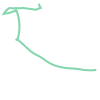

In [ ]:

LineString(df.geometry.iloc[0].coords[:500])

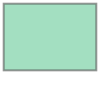

In [ ]:
import shapely
germany_wkt="POLYGON((6.346193586676736 54.32761585642789,15.135256086676735 54.32761585642789,15.135256086676735 48.00264900351188,6.346193586676736 48.00264900351188,6.346193586676736 54.32761585642789))"
germany_polygon = shapely.wkt.loads(germany_wkt)
germany_polygon

In [25]:
from here_location_services.config import dest_weather_config
# from shapely.geometry import LineString
def get_weather_for_route(route:LineString):
    coords = list(route.coords)
    if len(coords[0])==3:
        #deal with elevation
        coords = [x[:2] for x in coords]
    start=coords[0]
    mid = coords[len(coords)//2]
    dest = coords[-1]
    
    start_weather = here_api.get_dest_weather(at=start, products=[dest_weather_config.DEST_WEATHER_PRODUCT.forecastHourly])
    start_weather = pd.json_normalize(start_weather.response.get("places")[0].get("hourlyforecasts")[0].get("forecasts"))

    mid_weather = here_api.get_dest_weather(at=mid, products=[dest_weather_config.DEST_WEATHER_PRODUCT.forecastHourly])
    mid_weather=pd.json_normalize(mid_weather.response.get("places")[0].get("hourlyforecasts")[0].get("forecasts"))

    dest_weather = here_api.get_dest_weather(at=dest, products=[dest_weather_config.DEST_WEATHER_PRODUCT.forecastHourly])
    dest_weather=pd.json_normalize(dest_weather.response.get("places")[0].get("hourlyforecasts")[0].get("forecasts"))

    return start_weather, mid_weather, dest_weather

weather = get_weather_for_route(df.geometry.iloc[0])

In [55]:

rev = [list(reversed(x)) for x in corridor]
rev


[[8.310961, 53.17764],
 [8.52653, 53.05768],
 [9.03649, 53.02307],
 [9.62167, 52.81372],
 [9.88487, 52.42911],
 [10.4348, 52.33265],
 [11.03672, 52.22743],
 [11.8283, 52.22543],
 [12.81583, 52.33333],
 [13.17951, 52.39597],
 [13.40415, 52.51961]]

In [56]:
here_api.get_weather_alerts(LineString(rev),weather_type=dest_weather_config.WEATHER_TYPE.air_quality,weather_severity=dest_weather_config.WEATHER_SEVERITY.insignificant,start_time=datetime.datetime.now())

ApiError: 400, Bad Request, {"status":400,"title":"Invalid Request","code":"E611302","cause":"Maximum width is 25000, from request = 50000","action":null,"correlationId":null}

In [23]:
def request_here_traffic_incidents(route: LineString, corridor_width: int = 1000):
    """Request incidents from here.com. There is a limit on how many route can be included, but it's not mentioned in the api docs. Therefore it's capped to 10."""
    coords = list(route.coords)
    if len(coords[0]) == 3:
        # deal with elevation
        coords = [x[:2] for x in coords]
    corridor = [list(reversed(x[:2])) for x in coords]
    
    if len(corridor) > 10:
        corridor = corridor[slice(0, len(corridor), len(corridor) // 10)]
    print(corridor)
    response = traffic_api.incidents_in_corridor(corridor[:2], corridor_width)
    return response

resp = request_here_traffic_incidents(df.geometry.iloc[0])

[[53.17764, 8.310961], [53.05768, 8.52653], [53.02307, 9.03649], [52.81372, 9.62167], [52.42911, 9.88487], [52.33265, 10.4348], [52.22743, 11.03672], [52.22543, 11.8283], [52.33333, 12.81583], [52.39597, 13.17951], [52.51961, 13.40415]]


HEREError: Error occurred on __get